# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [45]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [46]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [47]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что это вероятности принадлежноти классу, а еще потому что здесь использована стратегия uniform, в которой все классы имеют равную вероятность.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [48]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


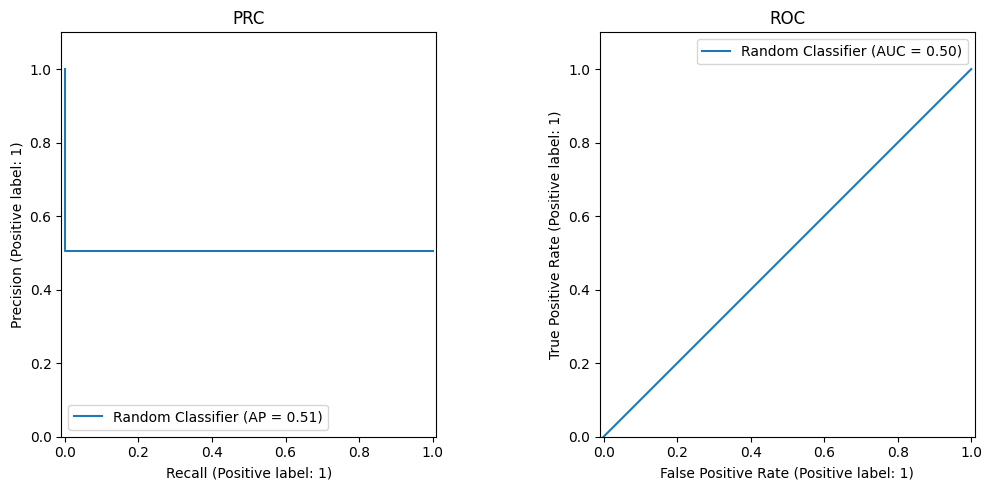

In [49]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [50]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [51]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_recall_curve, auc, roc_curve, roc_auc_score

In [52]:
def scorer(estimator, X, y):
    prediction = estimator.predict(X)
    precision, recall, thresholds = precision_recall_curve(y, prediction)
    return auc(recall, precision)

def get_classifier(classifier, reg_param):
    random_state = 123
    if classifier == 'LinearSVC':
        return LinearSVC(C=reg_param, random_state=random_state)
    if classifier == 'SVC':
        return SVC(kernel='linear', C=reg_param, random_state=random_state)
    if classifier == 'LogisticRegression':
        return LogisticRegression(C=reg_param, random_state=random_state)

def train_classifier(X_train, y_train, classifier_name, reg_params):
    best_score = 0
    best_score_ind = 0
    for ind, c in enumerate(reg_params):
        # create classifier
        classifier = get_classifier(classifier_name, c)
        # train classifier
        average_score = np.mean(cross_val_score(classifier, X=X_train, y=y_train, cv=KFold(n_splits=5), scoring=scorer))

        # update results
        if best_score < average_score:
            best_score = average_score
            best_score_ind = ind
        # visualize results
        print('Parameter=', c, ' | AUC-PR=', average_score, sep='')
    return best_score, reg_params[best_score_ind]

In [53]:
svc_best_score, svc_best_param = train_classifier(X_train, y_train,
                                                  classifier_name='LinearSVC',
                                                  reg_params=np.logspace(-4, 2, 10))

Parameter=9.999999999999999e-05 | AUC-PR=0.8323712047562388
Parameter=0.00046415888336127773 | AUC-PR=0.8336268593656488
Parameter=0.002154434690031882 | AUC-PR=0.8335206021586506
Parameter=0.01 | AUC-PR=0.8339126073053864
Parameter=0.046415888336127774 | AUC-PR=0.833677320724654
Parameter=0.21544346900318823 | AUC-PR=0.833677320724654
Parameter=1.0 | AUC-PR=0.833677320724654
Parameter=4.641588833612772 | AUC-PR=0.833677320724654
Parameter=21.54434690031882 | AUC-PR=0.833677320724654
Parameter=100.0 | AUC-PR=0.833677320724654


In [54]:
svc_best_score, svc_best_param

(0.8339126073053864, 0.01)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [55]:
def visualize_results(X_train, y_train, X_test, y_test, classifier):
    # train and prdict
    clf = classifier.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    # get metrics
    precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test))

    # visualize
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Metrics', fontsize='xx-large', color='purple')

    axs[0].plot(fpr, tpr, color='purple')
    axs[0].set_title('ROC', fontsize='x-large', color='violet')
    axs[0].set_xlabel('FPR', fontsize='x-large', color='violet')
    axs[0].set_ylabel('TPR', fontsize='x-large', color='violet')

    axs[1].plot(recall, precision, color='purple')
    axs[1].set_title('PR', fontsize='x-large', color='violet')
    axs[1].set_xlabel('Recall', fontsize='x-large', color='violet')
    axs[1].set_ylabel('Precision', fontsize='x-large', color='violet')

    # print results
    print('AUC-ROC=%0.6f' % auc(fpr, tpr))
    print('AUC-PR=%0.6f' % auc(recall, precision))

AUC-ROC=0.847623
AUC-PR=0.829603


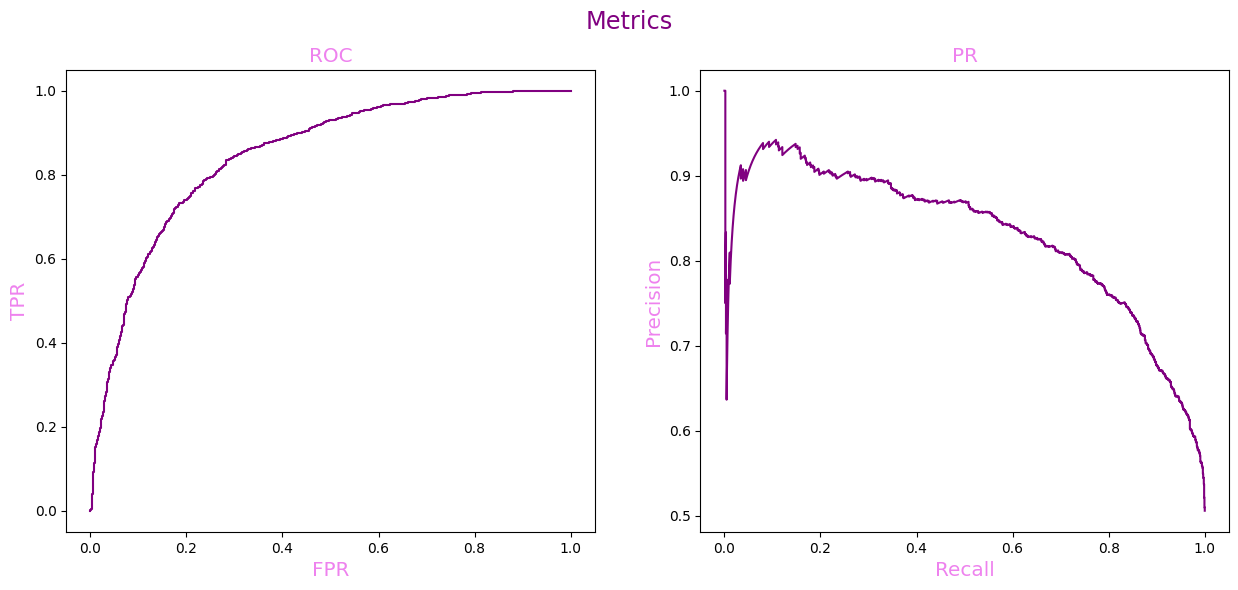

In [56]:
classifier = get_classifier('LinearSVC', svc_best_param)
visualize_results(X_train, y_train, X_test, y_test, classifier)

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?

1 график: При изменении порога меньше объектов классифицируются как положительные, и поэтому TPR и FPR растут.

2 график: Полнота уменьшается, а про точность нельзя наверняка сказать, куда она будет меняться.

- Монотонные ли кривые? Как вы это объясните?

1 график: монотонная.

2 график: не монотонная, тк порог снижается и мы включаем в положительный класс всё больше объектов, но какие-то из них могут оказаться ложноположительными, поэтому precision точечно провалился.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [57]:
# Явно видим, что качество на LinearSVC сильно лучше, чем на случайном классификаторе.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [58]:
logreg_best_score, logreg_best_param = train_classifier(X_train, y_train,
                                                  classifier_name='LogisticRegression',
                                                  reg_params=np.logspace(-4, 2, 10))

Parameter=9.999999999999999e-05 | AUC-PR=0.8219256127239228
Parameter=0.00046415888336127773 | AUC-PR=0.8284848847187947
Parameter=0.002154434690031882 | AUC-PR=0.831895756462889
Parameter=0.01 | AUC-PR=0.8335822805974689
Parameter=0.046415888336127774 | AUC-PR=0.8341069756145283
Parameter=0.21544346900318823 | AUC-PR=0.8341069756145283
Parameter=1.0 | AUC-PR=0.8342084588018464
Parameter=4.641588833612772 | AUC-PR=0.8342084588018464
Parameter=21.54434690031882 | AUC-PR=0.8342084588018464
Parameter=100.0 | AUC-PR=0.8342084588018464


In [59]:
logreg_best_score, logreg_best_param

(0.8342084588018464, 1.0)

AUC-ROC=0.847873
AUC-PR=0.829124


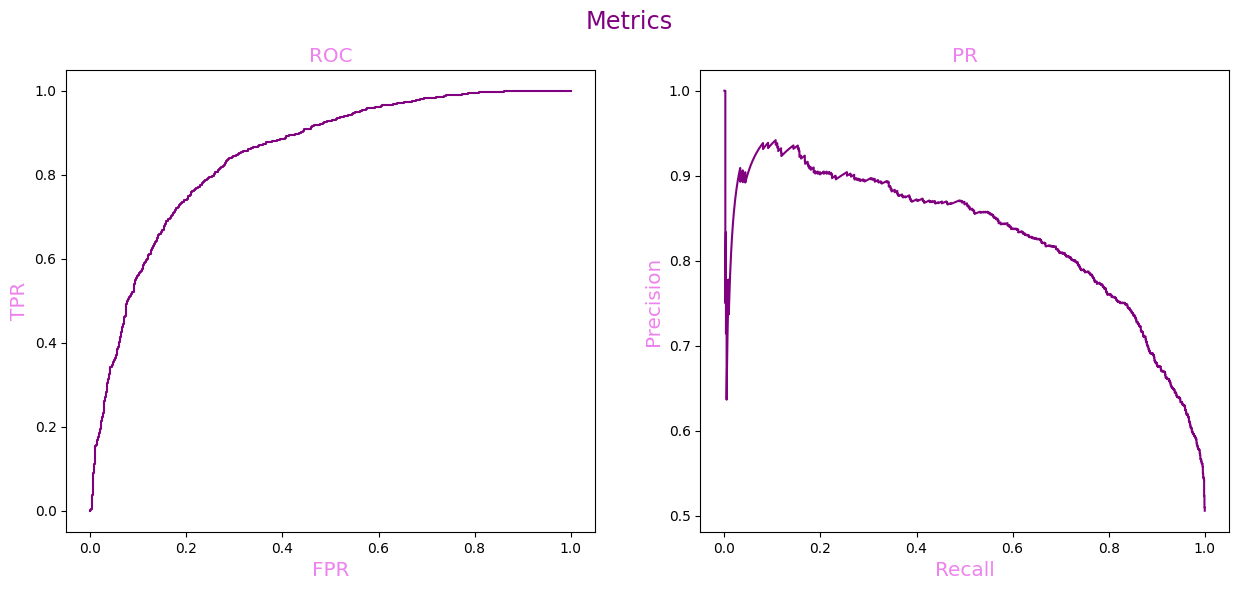

In [60]:
classifier = get_classifier('LogisticRegression', logreg_best_score)
visualize_results(X_train, y_train, X_test, y_test, classifier)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [61]:
# your code here

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий между логрегом и SVM в общем и нет, а классификатор сильно хуже первых двух.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

Нашла такое, воспользовалась: https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92

In [62]:
X, y = make_classification(n_samples=3000, n_features=2, n_informative=2, n_redundant=0, random_state=123)

classifier = get_classifier('SVC', svc_best_param).fit(X, y)

In [63]:
import matplotlib.cm as cm

def visualize_svc_vectors(X, y, classifier):
    support_vectors = classifier.support_vectors_

    plt.figure(figsize=(8, 8))
    plt.title('SVM classifier')

    xlim = [X[:, 0].min(), X[:, 0].max()]
    ylim = [X[:, 1].min(), X[:, 1].max()]

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = classifier.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='darkslategray', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PRGn', edgecolors='k')
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=70, linewidth=1.5, edgecolors='k')
    plt.show()

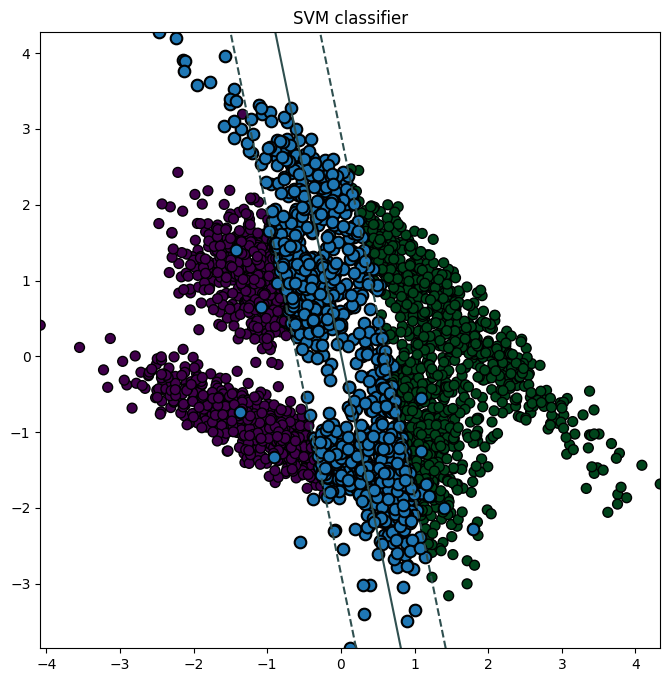

In [64]:
visualize_svc_vectors(X, y, classifier)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, которые ближе находятся к гиперплоскости

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [65]:
def visualize_svc_color(X, y, classifier):
    support_vectors = classifier.support_vectors_

    plt.figure(figsize=(8, 8))
    plt.title('SVM classifier')

    xlim = [X[:, 0].min(), X[:, 0].max()]
    ylim = [X[:, 1].min(), X[:, 1].max()]

    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = classifier.predict(xy).reshape(XX.shape)

    plt.pcolor(xx, yy, Z, cmap='PiYG', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='PRGn', edgecolors='k')
    plt.show()

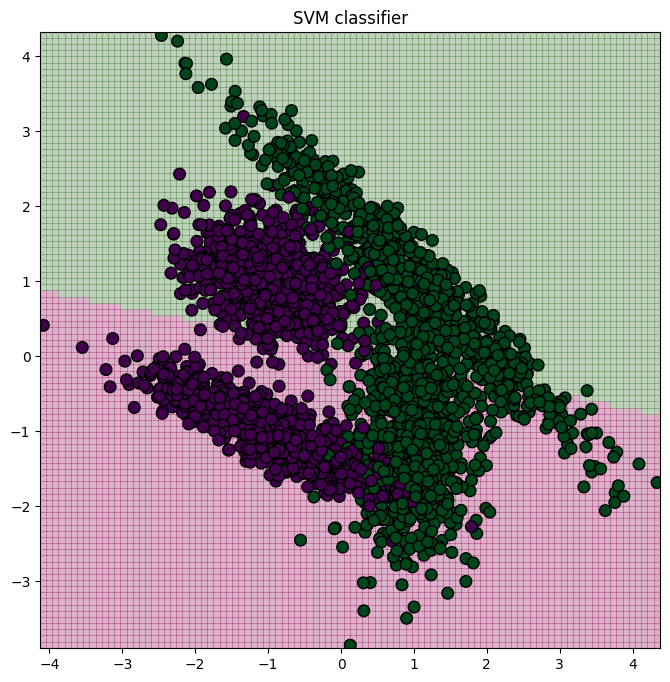

In [66]:
visualize_svc_color(X, y, classifier)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?

**Ответ:** Область неуверенности это линия на границе цветных зон, там модель считает объекты равновероятно принадлежащими обоим классам, поэтому и неуверена. Более теоретически: SVM делит объекты гиперплоскостью, которая как раз проходит там, где модель не уверена.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [67]:
def plot_calibration_curve(y_test, preds, classifier_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # тут была ошибка
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # и тут была ошибка

    plt.figure(figsize=(6,6))
    plt.ylim([-0.05, 1.05])
    plt.title('Calibration curve ' + classifier_name)
    plt.xlabel('Mean of predicted probabilities')
    plt.ylabel('Fraction of positive result')

    plt.plot([0, 1], [0, 1], linestyle='--', color='purple')
    plt.plot(bin_middle_points, bin_real_ratios, label=classifier_name)

    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

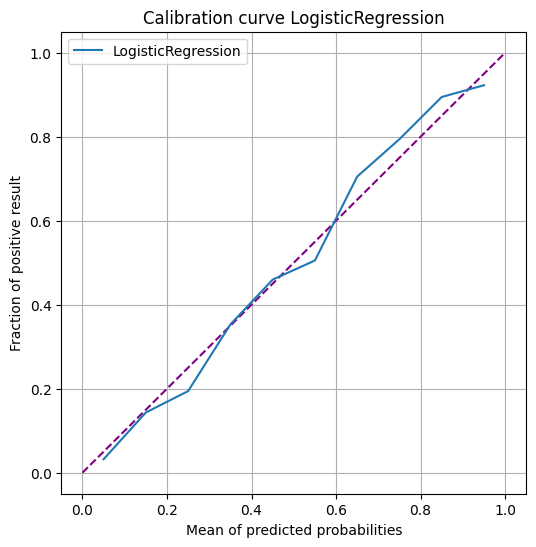

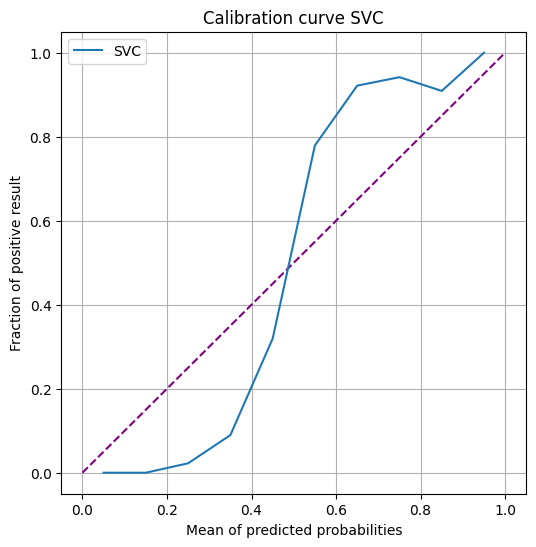

In [68]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

logreg = get_classifier('LogisticRegression', logreg_best_score).fit(X_train, y_train)
logreg_pred = logreg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, logreg_pred, 'LogisticRegression')

svc = get_classifier('SVC', svc_best_param).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred_norm = (svc_pred - np.min(svc_pred)) / (np.max(svc_pred) - np.min(svc_pred))
plot_calibration_curve(y_test, svc_pred_norm, 'SVC')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Логистическая регрессия лучше откалибрована, тк линии близко друг к другу, её предсказания можно использовать как вероятности события.
SVM плохо откалиброван, и его вероятности требуют дополнительной обработки перед использованием.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [69]:
from sklearn.metrics import log_loss, brier_score_loss

# LogLoss и Brier Score для логистической регрессии
logreg_logloss = log_loss(y_test, logreg_pred)
logreg_brier = brier_score_loss(y_test, logreg_pred)

print("Logistic regression calibration:")
print(f"LogLoss: {logreg_logloss:.4f}")
print(f"Brier Score: {logreg_brier:.4f}")

# LogLoss и Brier Score для SVC
svc_logloss = log_loss(y_test, svc_pred_norm)
svc_brier = brier_score_loss(y_test, svc_pred_norm)

print("\nSVC calibration:")
print(f"LogLoss: {svc_logloss:.4f}")
print(f"Brier Score: {svc_brier:.4f}")

Logistic regression calibration:
LogLoss: 0.4042
Brier Score: 0.1258

SVC calibration:
LogLoss: 0.5448
Brier Score: 0.1793


**Вывод:** у логистической регрессии меньшие значения метрик, значит, она лучше откалибрована, как я и написала раннее.

Изучите распределение ответов классификаторов при помощи гистограмм

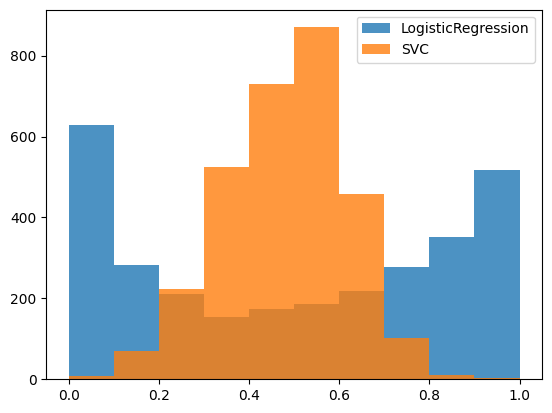

In [70]:
plt.hist(logreg_pred, alpha=0.8, label='LogisticRegression')
plt.hist(svc_pred_norm, alpha=0.8, label='SVC')
plt.legend()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Расределение ответов для `LogisticRegression` более менее равномерное, но у краёв области распределения ответов больше, чем в середине, это говорит о хорошей уверености классификатора в своём предсказании. У `SVC` большая часть ответов сосредоточена у 0.6, а по краям области определения ответов совсем мало, классификатор даёт какие-то слабые по уверенности предсказания.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [71]:
from sklearn.calibration import CalibratedClassifierCV

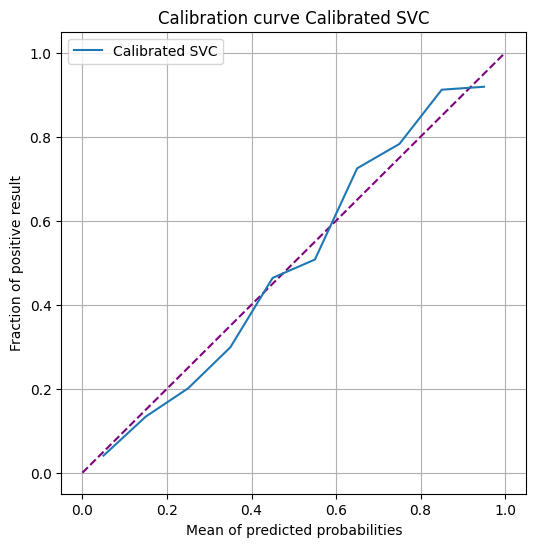

In [72]:
calibrated_svc = CalibratedClassifierCV(estimator=get_classifier('SVC', svc_best_param)).fit(X_train, y_train)
calibrated_svc_pred = calibrated_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, calibrated_svc_pred, 'Calibrated SVC')

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** конечно, стало заметно лучше

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [73]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [74]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [75]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [76]:
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numerical_features = ['ID', 'Children', 'Cars', 'Age']

# Прочитаем датасет
df = pd.read_csv(path)

# Заменим пропуски категориальных переменных
df[categorical_features] = df[categorical_features].fillna('undefined')

# Отделим X и y
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = df[numerical_features]
X_categorical = df[categorical_features]

In [77]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


В начале поработаем только с категориальными признаками

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from time import time

In [80]:
def pr_auc(target, prediction):
    precision, recall, _ = precision_recall_curve(target, prediction)
    return auc(recall, precision)

In [81]:
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numerical_features = ['ID', 'Income', 'Children', 'Cars', 'Age']

In [82]:
# start
start = time()

# train model
column_transformer = ColumnTransformer([
    ('encoder', OrdinalEncoder(), categorical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)

# end
end = time()

print('Train time:',  end - start)

Train time: 0.012096405029296875


In [83]:
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.585240
Test AUC-PR=0.579299


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [84]:
start = time()

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)

end = time()

print('Train time:',  end - start)

Train time: 0.016973018646240234


In [85]:
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.640483
Test AUC-PR=0.661474


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [86]:
df['Purchased Bike'] = (df['Purchased Bike'] == 'Yes').astype('int64')

In [87]:
# start of training
start = time()

# dictionary of encodings for each categorical column
category_columns = {}
# compute encodings for each column
for column in categorical_features:
    category_columns[column] = df.groupby(by=column)['Purchased Bike'].mean()
# encode test and train
for column in categorical_features:
    X_train[column] = X_train[column].map(category_columns[column])
    X_test[column] = X_test[column].map(category_columns[column])

# train model
pipeline = Pipeline(
    steps=[
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)

# end of training
end = time()

print('Train time:',  end - start)

Train time: 0.01826620101928711


In [88]:
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.624759
Test AUC-PR=0.703260


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

In [91]:
class MTE(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.category_columns = {}

    def fit(self, X, y):
        data = X.copy()
        data['ans'] = y.copy()
        for column in X.columns:
            self.category_columns[column] = data.groupby(by=column)['ans'].mean()
        return self

    def transform(self, X, y=None):
        new_X = X.copy()
        for column in X.columns:
            new_X[column] = new_X[column].map(self.category_columns[column])
        return new_X

In [92]:
# start
start = time()

# train
column_transformer = ColumnTransformer([
    ('encoder', MTE(), categorical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)

# end
end = time()

print('Train time:',  end - start)

Train time: 0.019919633865356445


In [93]:
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.631891
Test AUC-PR=0.652636


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [94]:
class MTENoise(BaseEstimator, TransformerMixin):
    def __init__(self, noise=None):
        self.category_columns = {}
        self.noise = noise

    def fit(self, X, y):
        data = X.copy()
        data['ans'] = y.copy()
        for column in X.columns:
            self.category_columns[column] = data.groupby(by=column)['ans'].mean()
        return self

    def transform(self, X, y=None):
        new_X = X.copy()
        for column in X.columns:
            new_X[column] = new_X[column].map(self.category_columns[column])
            if not self.noise is None:
                new_X[column] += np.random.normal(scale=self.noise, size=new_X.shape[0])
        return new_X

In [95]:
column_transformer = ColumnTransformer([
    ('encoder', MTENoise(noise=0.03), categorical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.614851
Test AUC-PR=0.625387


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** немного ухудшилось качество, это могло случиться потому что сдвинулось распределение данных, либо из-за уменьшения полезной информативности признаков

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [96]:
class MTESmmothNoise(BaseEstimator, TransformerMixin):
    def __init__(self, noise=None, smooth=None):
        self.category_columns = {}
        self.noise = noise
        self.smooth = smooth

    def fit(self, X, y):
        data = X.copy()
        data['ans'] = y.copy()
        for column in X.columns:
            if not self.smooth is None:
                grouped = data.groupby(by=column)
                first = grouped['ans'].sum() + self.smooth * data['ans'].mean()
                second = grouped.size() + self.smooth
                self.category_columns[column] = first / second
            else:
                self.category_columns[column] = data.groupby(by=column)['ans'].sum()
        return self

    def transform(self, X, y=None):
        new_X = X.copy()
        for column in X.columns:
            new_X[column] = new_X[column].map(self.category_columns[column])
            if not self.noise is None:
                new_X[column] += np.random.normal(scale=self.noise, size=new_X.shape[0])
        return new_X

In [97]:
column_transformer = ColumnTransformer([
    ('encoder', MTESmmothNoise(smooth=10), categorical_features),
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.625629
Test AUC-PR=0.668968


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [99]:
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numerical_features = ['ID', 'Children', 'Cars', 'Age']

In [100]:
train_ages = set(X_train['Age'].unique())
test_ages = set(X_test['Age'].unique())

ind = X_train[X_train['Age'].isin(train_ages - test_ages)].index
X_train.drop(index=ind, inplace=True)
y_train.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

ind = X_test[X_test['Age'].isin(test_ages - train_ages)].index
X_test.drop(index=ind, inplace=True)
y_test.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

Удалили объектов: 15
Удалили объектов: 0


In [101]:
train_cars = set(X_train['Cars'].unique())
test_cars = set(X_test['Cars'].unique())

ind = X_train[X_train['Cars'].isin(train_cars - test_cars)].index
X_train.drop(index=ind, inplace=True)
y_train.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

ind = X_test[X_test['Cars'].isin(test_cars - train_cars)].index
X_test.drop(index=ind, inplace=True)
y_test.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

Удалили объектов: 0
Удалили объектов: 0


In [102]:
train_children = set(X_train['Children'].unique())
test_children = set(X_test['Children'].unique())

ind = X_train[X_train['Children'].isin(train_children - test_children)].index
X_train.drop(index=ind, inplace=True)
y_train.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

ind = X_test[X_test['Children'].isin(test_children - train_children)].index
X_test.drop(index=ind, inplace=True)
y_test.drop(index=ind, inplace=True)
print('Удалили объектов:', len(ind))

Удалили объектов: 0
Удалили объектов: 0


In [103]:
train_mean = X_train[['Children', 'Cars', 'Age']].mean()

X_train[['Children', 'Cars', 'Age']]= X_train[['Children', 'Cars', 'Age']].fillna(train_mean)
X_test[['Children', 'Cars', 'Age']]= X_test[['Children', 'Cars', 'Age']].fillna(train_mean)

In [104]:
new_categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region',
                            'Children', 'Cars', 'Age']
new_numerical_features = ['ID']

X_train = X_train.drop(columns=new_numerical_features)
X_test = X_test.drop(columns=new_numerical_features)

In [105]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), new_categorical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.762536
Test AUC-PR=0.685435


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [106]:
column_transformer = ColumnTransformer([
    ('encoder', MTESmmothNoise(smooth=10), new_categorical_features),
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.734607
Test AUC-PR=0.657317


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы: меньше размерность, больше информативность

Минусы: возможна потеря полезных данных, можно не заметить нелинейные связи между признаками и таргетом

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [107]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-01 12:20:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.75MB/s    in 0.5s    

2024-12-01 12:20:15 (7.75 MB/s) - ‘adult.data’ saved [3974305]



In [108]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13423,36,Local-gov,109766,Bachelors,13,Never-married,Protective-serv,Not-in-family,White,Male,0,0,60,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['income']), df['income'],
                                                    test_size=0.25, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [110]:
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'native-country',
                        'race', 'sex']
numerical_features = ['age', 'fnlwgt', 'education-num',
                      'capital-gain', 'capital-loss', 'hours-per-week']

In [111]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
])

In [112]:
before = X_train.shape[1]
after = column_transformer.fit_transform(X_train).shape[1]

print('Before transform:', before)
print('After transform:', after)
print('Number of new features:', after - len(numerical_features))

Before transform: 14
After transform: 102
Number of new features: 96


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [113]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)
classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.771366
Test AUC-PR=0.767160


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [114]:
start = time()

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])

X_train_new = column_transformer.fit_transform(X_train)

classifier = LogisticRegression().fit(X_train_new, y_train)

best_features = np.argsort(-np.abs(classifier.coef_[0]))[:40]
print('Best features found in time:', time() - start)

X_train_new = X_train_new[:, best_features]
classifier = LogisticRegression().fit(X_train_new, y_train)

end = time()

print('Train time:',  end - start)

Best features found in time: 0.2314136028289795
Train time: 0.3097844123840332


In [115]:
X_test_new = column_transformer.transform(X_test)[:, best_features]

train_pred = classifier.decision_function(X_train_new)
test_pred = classifier.decision_function(X_test_new)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.748223
Test AUC-PR=0.738772


Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [116]:
from sklearn.feature_selection import SelectFromModel
# start
start = time()

# take best features
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('feature selection', SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=40)),
        ('classificator', LogisticRegression()),
    ]
)

# fit
classifier = pipeline.fit(X_train, y_train)

# end
end = time()

print('Train time:',  end - start)

Train time: 0.3370952606201172


In [117]:
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.748223
Test AUC-PR=0.738772


 Изменилось ли качество? Как?


 Ухудшилось((( Видимо т.к. повыкидывали полезных признаков

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

До этого как раз мы масштабировали числовые признаки перед выбором лучших, поэтому теперь время экспериментов: не масштабируем признаки вообще.

In [118]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('feature selection', SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=40)),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.676393
Test AUC-PR=0.657634


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [119]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('scaling', StandardScaler(with_mean=False)),
        ('feature selection', SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=40)),
        ('classificator', LogisticRegression()),
    ]
)

classifier = pipeline.fit(X_train, y_train)
train_pred = classifier.decision_function(X_train)
test_pred = classifier.decision_function(X_test)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.683536
Test AUC-PR=0.678831


In [120]:
# масштабируем только numeric
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
X_train_1 = column_transformer.fit_transform(X_train)
model_1 = SelectFromModel(estimator=LogisticRegression(), max_features=40).fit(X_train_1, y_train)

# масштабируем все
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
])
X_train_2 = StandardScaler(with_mean=False).fit_transform(column_transformer.fit_transform(X_train))
model_2 = SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=40).fit(X_train_2, y_train)

print(*np.where(model_1.get_support()), *np.where(model_2.get_support()), sep='\n\n')

[  1   8  12  22  25  26  27  28  29  30  31  36  37  40  41  42  43  45
  49  50  52  54  55  57  58  59  61  63  64  65  75  77  80  83  88  93
  95 100 104 105]

[  6   7   8   9  10  12  13  14  15  18  19  20  21  22  23  24  25  27
  29  30  32  36  37  38  39  40  41  42  47  48  49  50  52  57  79  81
  92  97  99 100]


Качество у второго способа сильно ниже, чем у первого, а список признаков у них разный

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** высокая корреляция признака и таргета говорит о том, что признак действительно важен для модели, поэтому такие признаки нужно оставлять при обучении

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [338]:
# your code here

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [121]:
def t_stat(column, target):
    neg_mask = (target == 0)
    neg_size = neg_mask.sum()
    pos_size = target.shape[0] - neg_size

    pos_mu, neg_mu = column[~neg_mask].mean(), column[neg_mask].mean()
    pos_std, neg_std = column[~neg_mask].std(), column[neg_mask].std()

    return np.abs(pos_mu - neg_mu) / np.sqrt((pos_size * pos_std ** 2 + neg_size * neg_std ** 2) / target.shape[0])

In [122]:
start = time()

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
])

X_train_new = column_transformer.fit_transform(X_train)
t_stat_columns = np.apply_along_axis(lambda x: t_stat(x, y_train), axis=0, arr=X_train_new.toarray())
best_features = np.argsort(-np.abs(t_stat_columns))[:40]
print('Best features found in time:', time() - start)

X_train_new = X_train_new[:, best_features]
classifier = LogisticRegression().fit(X_train_new, y_train)

end = time()

print('Train time:',  end - start)

Best features found in time: 0.22110223770141602
Train time: 0.2744472026824951


In [123]:
X_test_new = column_transformer.transform(X_test)[:, best_features]

train_pred = classifier.decision_function(X_train_new)
test_pred = classifier.decision_function(X_test_new)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.684464
Test AUC-PR=0.685625


Качество все равно хуже, чем при обычном масштабировании числовых признаков

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['income']), df['income'],
                                                    test_size=0.25, random_state=777, stratify=df['income'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25, random_state=777, stratify=y_train)
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
X_train_new = column_transformer.fit_transform(X_train).toarray()
X_val_new = column_transformer.transform(X_val).toarray()

number_of_drop = X_train_new.shape[1] - 40
number_of_drop

68

In [125]:
start = time()

delete_feature_ind = []
used_ind = [0] * X_train_new.shape[1]
for _ in range(number_of_drop):
    max_score = -1
    index = -1
    for j in range(X_train_new.shape[1]):
        if used_ind[j] == 1:
            continue
        clf = LogisticRegression().fit(np.delete(X_train_new, delete_feature_ind + [j], axis=1), y_train)
        score = pr_auc(y_val, clf.decision_function(np.delete(X_val_new, delete_feature_ind + [j], axis=1)))
        if score > max_score:
            max_score = score
            index = j
    delete_feature_ind.append(index)
    used_ind[index] = 1

print('Best features found in time:', time() - start)
print(delete_feature_ind)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best features found in time: 918.6465129852295
[77, 58, 86, 29, 62, 92, 28, 76, 16, 19, 14, 56, 46, 39, 1, 74, 3, 94, 69, 22, 34, 70, 51, 48, 91, 11, 89, 9, 67, 12, 20, 18, 13, 99, 17, 85, 66, 97, 96, 82, 68, 90, 0, 15, 24, 71, 57, 87, 60, 81, 47, 101, 88, 78, 54, 80, 98, 84, 30, 37, 75, 63, 8, 64, 53, 41, 25, 10]


In [126]:
X_train_new = np.delete(X_train_new, delete_feature_ind, axis=1)
X_test_new = np.delete(column_transformer.transform(X_test).toarray(), delete_feature_ind, axis=1)

classifier = LogisticRegression().fit(X_train_new, y_train)
train_pred = classifier.decision_function(X_train_new)
test_pred = classifier.decision_function(X_test_new)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.768016
Test AUC-PR=0.765389


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [127]:
X_train_new = column_transformer.fit_transform(X_train).toarray()
X_val_new = column_transformer.transform(X_val).toarray()

In [128]:
start = time()

save_feature_ind = []
used_ind = [0] * X_train_new.shape[1]
for _ in range(40):
    min_score = 2
    index = -1
    for j in range(X_train_new.shape[1]):
        if used_ind[j] == 1:
            continue
        clf = LogisticRegression().fit(np.delete(X_train_new, save_feature_ind + [j], axis=1), y_train)
        score = pr_auc(y_val, clf.decision_function(np.delete(X_val_new, save_feature_ind + [j], axis=1)))
        if score < min_score:
            min_score = score
            index = j
    save_feature_ind.append(index)
    used_ind[index] = 1

print('Best features found in time:', time() - start)
print(save_feature_ind)

Best features found in time: 617.2876150608063
[105, 106, 102, 107, 55, 63, 42, 40, 38, 36, 35, 103, 37, 39, 64, 65, 32, 68, 87, 71, 94, 90, 3, 69, 67, 74, 27, 28, 73, 9, 72, 11, 80, 81, 66, 93, 22, 56, 84, 62]


In [129]:
X_train_new = X_train_new[:, save_feature_ind]
X_test_new = column_transformer.transform(X_test).toarray()[:, save_feature_ind]

classifier = LogisticRegression().fit(X_train_new, y_train)
train_pred = classifier.decision_function(X_train_new)
test_pred = classifier.decision_function(X_test_new)

print('Train AUC-PR=%0.6f' % pr_auc(y_train, train_pred))
print('Test AUC-PR=%0.6f' % pr_auc(y_test, test_pred))

Train AUC-PR=0.731416
Test AUC-PR=0.729914


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Последние два метода  долгие даже на А100, при этом в качестве не дают сильного прироста. К супер качеству привёл второй метод, он и работает быстрее.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [130]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-01 12:49:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.38MB/s    in 0.3s    

2024-12-01 12:49:36 (1.38 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [131]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [132]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [133]:
from collections import defaultdict
from sklearn.model_selection import KFold

k_folds = KFold(n_splits=5, random_state=500, shuffle=True)

In [134]:
categorical_features = ['job', 'marital', 'education', 'default',
                        'housing', 'loan', 'contact', 'month', 'day_of_week',
                        'poutcome',]
numerical_features = ['age', 'campaign', 'pdays', 'previous',
                      'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [135]:
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [136]:
revenue, profit, loss = [], [], []
for train_index, test_index in k_folds.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    clf = pipeline.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    revenue.append((prediction & y_test).sum() * 10)
    loss.append(prediction.sum())
    profit.append(revenue[-1] - loss[-1])
    index += 1
    print('Test AUC-PR=%0.6f' % pr_auc(y_test, prediction))

Test AUC-PR=0.524937
Test AUC-PR=0.478405
Test AUC-PR=0.474366
Test AUC-PR=0.509433
Test AUC-PR=0.457383


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [137]:
print('Average revenue:', np.mean(revenue))
print('Revenue STD:', np.std(revenue))
print('Average profit:', np.mean(profit))
print('Profit STD:', np.std(profit))
print('Average loss:', np.mean(loss))
print('Loss STD:', np.std(loss))

Average revenue: 2128.0
Revenue STD: 91.9565114605812
Average profit: 1805.8
Profit STD: 95.3003672605725
Average loss: 322.2
Loss STD: 8.423775875461075


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [138]:
revenue, profit, loss = [], [], []
for train_index, test_index in k_folds.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    clf = pipeline.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    revenue.append((prediction & y_test).sum() * np.random.rand() * 20)
    loss.append(prediction.sum())
    profit.append(revenue[-1] - loss[-1])
    index += 1
    print('Test AUC-PR=%0.6f' % pr_auc(y_test, prediction))

print('Average revenue:', np.mean(revenue))
print('Revenue STD:', np.std(revenue))
print('Average profit:', np.mean(profit))
print('Profit STD:', np.std(profit))
print('Average loss:', np.mean(loss))
print('Loss STD:', np.std(loss))

Test AUC-PR=0.524937
Test AUC-PR=0.478405
Test AUC-PR=0.474366
Test AUC-PR=0.509433
Test AUC-PR=0.457383
Average revenue: 1378.634055742568
Revenue STD: 924.5710953489998
Average profit: 1056.434055742568
Profit STD: 924.0695954196431
Average loss: 322.2
Loss STD: 8.423775875461075


Средние значения везде немного изменились, а для выручки и прибыли выросла дисперсия.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [139]:
def profit_scorer(estimator, X, y):
    prediction = estimator.predict(X)
    revenue = (prediction & y).sum() * np.random.rand() * 20
    loss = prediction.sum()
    return revenue - loss

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
    ]
)

best_profit = 0
best_profit_ind = 0
reg_params = np.linspace(0.01, 300, 10)
avg_profits, std_profits = [], []
for ind, c in enumerate(reg_params):
    # train classifier
    pipeline = Pipeline(
        steps=[
            ('transform', column_transformer),
            ('classificator', LogisticRegression(C=c)),
    ])
    profits = cross_val_score(pipeline, X=X, y=y, cv=k_folds, scoring=profit_scorer)
    average_profit = np.mean(profits)
    std_profit = np.std(profits)
    # update results
    if best_profit < average_profit:
        best_profit = average_profit
        best_profit_ind = ind
    avg_profits.append(average_profit)
    std_profits.append(std_profit)
    # visualize results
    print('Parameter=', c, ' | profit=', average_profit, sep='')

Parameter=0.01 | profit=1159.125110224127
Parameter=33.34222222222222 | profit=1695.654881511875
Parameter=66.67444444444445 | profit=2389.197095930237
Parameter=100.00666666666667 | profit=2711.763828041586
Parameter=133.33888888888887 | profit=1934.858121501844
Parameter=166.6711111111111 | profit=1666.1341388661185
Parameter=200.00333333333333 | profit=1951.8302794230235
Parameter=233.33555555555554 | profit=1847.5323371294435
Parameter=266.66777777777776 | profit=2531.951101904685
Parameter=300.0 | profit=1318.8167057418018


In [140]:
best_profit, reg_params[best_profit_ind]

(2711.763828041586, 100.00666666666667)

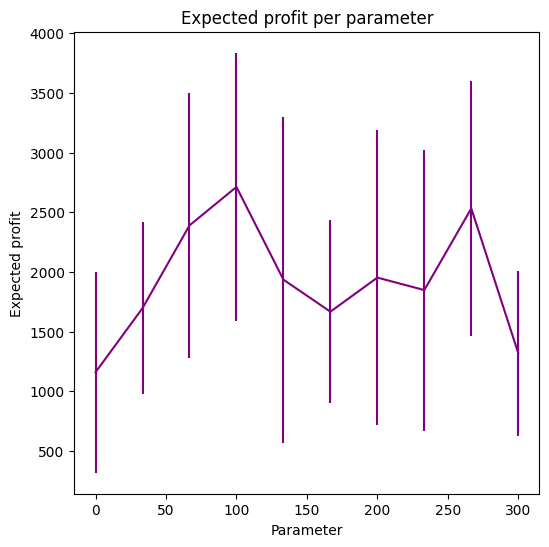

In [141]:
plt.figure(figsize=(6,6))
plt.errorbar(reg_params, avg_profits, std_profits, color='purple')
plt.title('Expected profit per parameter')
plt.ylabel('Expected profit')
plt.xlabel('Parameter')
plt.show()

Да, получилось лучше!

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [142]:
reg_params = np.linspace(0.01, 300, 10)
for _ in range(5):
    best_profit = 0
    best_profit_ind = 0
    for ind, c in enumerate(reg_params):
        # train classifier
        pipeline = Pipeline(
            steps=[
                ('transform', column_transformer),
                ('classificator', LogisticRegression(C=c)),
        ])
        profits = cross_val_score(pipeline, X=X, y=y, cv=k_folds, scoring=profit_scorer)
        average_profit = np.mean(profits)
        # update results
        if best_profit < average_profit:
            best_profit = average_profit
            best_profit_ind = ind
    # visualize results
    print('Best profit=', average_profit, ', best parameter=', c, sep='')

Best profit=1684.0666004635532, best parameter=300.0
Best profit=2834.2271773643556, best parameter=300.0
Best profit=1468.8428768084905, best parameter=300.0
Best profit=1051.1725346025694, best parameter=300.0
Best profit=1358.3376512087857, best parameter=300.0


Предсказания очень случайны, для одно и того же параметра получаются совершенно разные значения, причём лучший параметр в 1 эксперементе отличается от параметров в последнем эксперементе. Это возможно связано с тем, что само предсказание имеет большую дисперсию.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В данном случае для нас важны ложно отрицательные результаты, так как мы теряем денюжки на таких штуках. Нам не страшно, если мы не обзвоним в полном объёме людей, которые будут потенциальными клиентами, нам важнее чтобы среди обзваниваемых было как можно меньше отрицательных клиентов.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [144]:
pipeline = Pipeline(
    steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
])
# новая метрика не придумана

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [145]:
avg_revenue, avg_profit, avg_loss = [], [], []
avg_precision, avg_recall = [], []

thrs = np.linspace(0, 1, 100)
for threshold in thrs:
    revenue, profit, loss = [], [], []
    precision, recall = [], []
    for train_index, test_index in k_folds.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        clf = pipeline.fit(X_train, y_train)
        prediction = np.where(clf.predict_proba(X_test)[:,1] > threshold, 1, 0)

        revenue.append((prediction & y_test).sum() * np.random.rand() * 20)
        loss.append(prediction.sum())
        profit.append(revenue[-1] - loss[-1])

        p, r, _ = precision_recall_curve(y_test, prediction)
        precision.append(p)
        recall.append(r)

    avg_revenue.append(np.mean(revenue))
    avg_loss.append(np.mean(loss))
    avg_profit.append(np.mean(profit))
    avg_precision.append(np.mean(precision))
    avg_recall.append(np.mean(recall))
    print('Parameter:', threshold,
          '\n\tAverage precision:', avg_precision[-1],
          '\n\tAverage recall:', avg_recall[-1],
          '\n\tAverage profit:', avg_profit[-1])

Parameter: 0.0 
	Average precision: 0.5563270813370222 
	Average recall: 0.5 
	Average profit: 3613.0807082311885
Parameter: 0.010101010101010102 
	Average precision: 0.40845336728221343 
	Average recall: 0.6666666666666666 
	Average profit: -2170.1191215462327
Parameter: 0.020202020202020204 
	Average precision: 0.4086715751681204 
	Average recall: 0.6654564260997332 
	Average profit: -217.9380265786731
Parameter: 0.030303030303030304 
	Average precision: 0.41096571800254067 
	Average recall: 0.6569855549506507 
	Average profit: 3383.4281695521045
Parameter: 0.04040404040404041 
	Average precision: 0.41746507656640897 
	Average recall: 0.6396867803614091 
	Average profit: 4120.782125082911
Parameter: 0.05050505050505051 
	Average precision: 0.4258420993454623 
	Average recall: 0.6185370467772098 
	Average profit: 5664.111423460212
Parameter: 0.06060606060606061 
	Average precision: 0.4365468004537307 
	Average recall: 0.5975151969645964 
	Average profit: 2415.2071090931945
Parameter: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ брускетту с хамончиком